# Autoencoder for PETALO

Esta red la vamos a utilizar para comprimir los datos del anillo de 5mm de pitch radius 161mm

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de ficheros de Vicente


El fichero que ontroducimos es el p_OF_6mm0.h5

In [2]:
import pandas as pd
filename = '../datos_octubre_2018/p_OF_5mm_161mm000.h5'
conjunto_datos=pd.read_hdf(filename,'MC');
conjunto_datos.shape


(6320, 3840)

## Network parameters from matlab:

In [3]:
import scipy.io as sio
import hdf5storage
# empezamos con el autoencoder A de dimensión 576-250-576 (36 columnas x 16 filas de sensores )
datos_matlab= hdf5storage.loadmat('../datos_octubre_2018/compresores_pitch5mm_rad161mm_1_medio_ver1_export.mat')
encoder_weights_A= datos_matlab.get('encoder_weights_A')
encoder_biases_A= datos_matlab.get('encoder_biases_A')
decoder_weights_A= datos_matlab.get('decoder_weights_A')
decoder_biases_A= datos_matlab.get('decoder_biases_A')
min_A=datos_matlab.get('minA')
max_A=datos_matlab.get('maxA')
Encoder_weights_A=encoder_weights_A.transpose()
Encoder_biases_A=encoder_biases_A.transpose()[0]
Decoder_weights_A=decoder_weights_A.transpose()
Decoder_biases_A=decoder_biases_A.transpose()[0]


#Encoder_biases[0]

## Creación de los modelos KERAS del  autoencoders

Vamos a crear los dos autoencoders compresores como modelos Keras. En principio no los voy a utilizar; pero es posible que en un futuro sea necesario

In [5]:
    
encoding_dimA = 320  # floats -> compression of factor 2, assuming the input is 480 floats

# input image dimensions = sensor dimensions
img_rows, img_colsA = 16, 40
input_output_dim_A=img_rows*img_colsA
# this is our input placeholder
input_img_A = Input(shape=(input_output_dim_A,))
# "encoded" is the encoded representation of the input
encoded_A = Dense(encoding_dimA, activation='sigmoid',use_bias=True, weights=[Encoder_weights_A,Encoder_biases_A] )(input_img_A)
# "decoded" is the lossy reconstruction of the input
decoded_A = Dense(input_output_dim_A, activation='linear',use_bias=True, weights=[Decoder_weights_A,Decoder_biases_A] )(encoded_A)

# this model maps an input to its reconstruction
autoencoder_matlab_A = Model(input_img_A, decoded_A)
# autoencoder_matlab.get_weights()

## Prepare data into training and test set.

Vamos a generar las matrices de datos para la red neuronal . En esta seccion de código cambio de recorrer fila a fila (Paola) a recorrer columna a columna

In [7]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
L1B=0;
# hay dos L1 con 640 sensores (40*16)
X_train=conjunto_datos.values;
x_train=X_train;

for i in range (X_train.shape[0]):
    idea1=X_train[i,:].reshape(img_rows,(L1A*img_colsA));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_colsA)*img_rows);
    x_train[i,:] =idea2;
x_test = x_train;
print(x_train.shape)
print(x_test.shape)

(6320, 3840)
(6320, 3840)


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces
y otra red la B que se utiliza 1 vez

In [25]:

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))

cara_externa=x_test[:,0: L1A*input_output_dim_A] 
cara_externa_reconstruida=np.zeros((x_test.shape[0],L1A*input_output_dim_A))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    entrada_imgs_A=(ideaA) #he quitado el escalado
    encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    
 
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))

    #print(hola.shape)
    salida_total=hola1
    #salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
  

## Visualizamos los resultados

Visualizamos todos los sensores: 

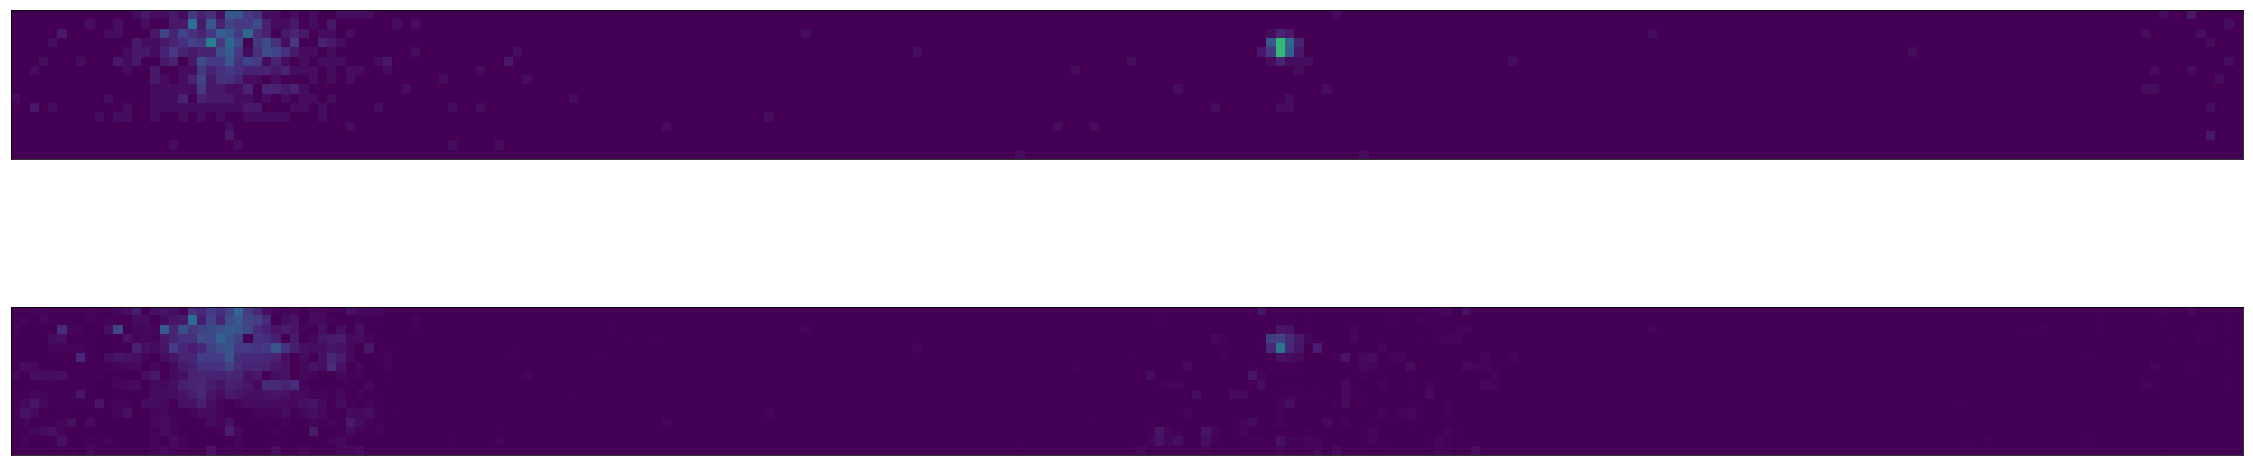

In [29]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

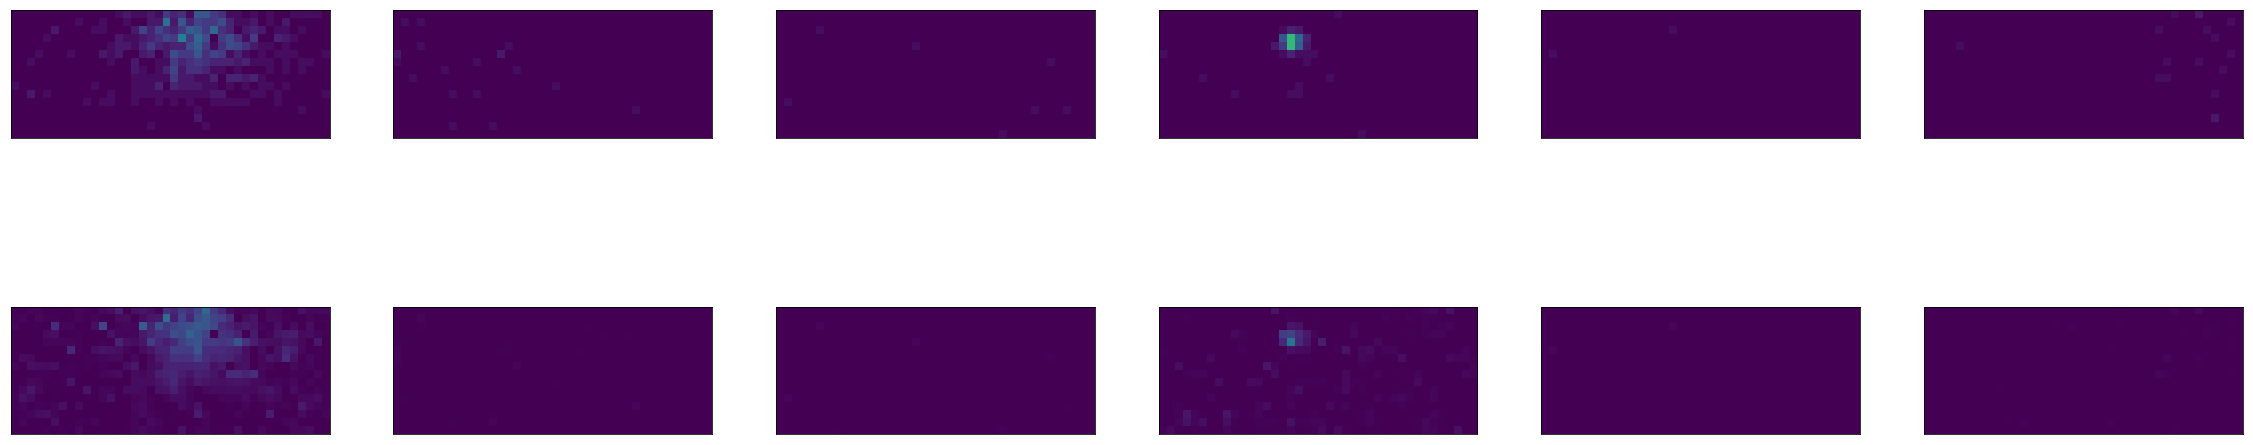

In [30]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [31]:
i=0
print(cara_externa[idea].reshape(L1A*img_colsA,img_rows)[i*img_colsA:(i+1)*img_colsA,:])
print(np.sum(cara_externa[idea].reshape(L1A*img_colsA,img_rows)[i*img_colsA:(i+1)*img_colsA,:]))

[[ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  1  0  0  2  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  1  1  0  0  0  1  1  0  0  0  0]
 [ 1  0  0  2  2  2  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  0  1  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  2  1  1  0  2  2  1  1  1  1  0  0  0  0]
 [ 1  0  6  2  3  2  0  1  1  1  1  0  0  0  0  0]
 [ 2  2  3  3  5  3  0  0  1  1  1  0  0  0  1  0]
 [ 1  2  6  4  3  0  1  1  1  3  1  1  0  0  0  0]
 [ 5 11  4  6  2  2  1  3  1  0

In [32]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_colsA,img_rows)[i*img_colsA:(i+1)*img_colsA,:].astype(int))
print(np.sum(cara_externa_reconstruida[idea].reshape(L1A*img_colsA,img_rows)[i*img_colsA:(i+1)*img_colsA,:]))

[[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  3  1  0  0  0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  1  0  0  0  0  0 -2]
 [ 0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  1  0  0  0  0  0  0  0  0 -1  0]
 [ 1  0  0  1  0  1  0  0  0  0  0  1  0  0 -1  0]
 [ 2  0  0  0  2  1  0 -1  0  0  0  0 -1  0  0  0]
 [-1  1  0  0  1  0  0  1  0  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  0  0  1  0  1  1  0  0  0  0  0]
 [ 1  0  8  2  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  1  3  3  5  1  0  0  1  1  0  0  0  0  0  0]
 [ 0  2  7  4  3  2  2  1  2  1  1  0  0  0  0  0]
 [ 4 10  4  4  2  3  2  2  2  2